# Reference: RL Model Code

### 3a) human_reward_move

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from utils import *

In [2]:
import os
path=os.path.join('data','rps_v2_clean.csv')
df = pd.read_csv(path)

In [3]:
## add new columns to count the number of each reward
new_df = add_col(df, ['rock_reward', 'paper_reward','scissors_reward',], value =0)
new_df

df = add_col(new_df, ['opponent_move'], value ='')
def get_opponent_move(sub_df):
    """
    fills in the `opponent_move` column
    """
    for i in range(len(sub_df)):
        if i%2 == 0:
            sub_df.at[i, 'opponent_move'] = sub_df.at[i + 1, 'player_move']
        else:
            sub_df.at[i, 'opponent_move'] = sub_df.at[i - 1, 'player_move']
    
    return sub_df

separated = separate_df(df)
for e in separated:
    get_opponent_move(e)
df = pd.concat(separated)

In [4]:
# 3 points for a win, 0 for a tie, -1 for a loss
def human_reward_move(sub_df): 
    '''
    tally human rewards on previous rock, paper, or scissors moves
    '''
    # number of reward points for each move
    dic_reward={'win':3,'tie':0,'loss':-1}

    # initialization for each move
    dic_move={'rock':0,'paper':0,'scissors':0}

    # loop through the human rows
    for i in range(0,len(sub_df),2):

        # fetch player outcomes
        outcome=sub_df.get('player_outcome').iloc[i]

        # fetch player moves
        move=sub_df.get('player_move').iloc[i]

        # avoid all the nans and 'none's in player_move
        if move != 'none'and not pd.isna(move): 

            # tally all the point associated with rewards
            dic_move[move]+=dic_reward[outcome]

            # add columns to store reward points
            col_name=move+'_reward'

            # store reward points in corresponding columns
            sub_df.at[i,'rock_reward']=dic_move['rock']
            sub_df.at[i,'paper_reward']=dic_move['paper']
            sub_df.at[i,'scissors_reward']=dic_move['scissors']

    return sub_df 

separated = separate_df(df)
for e in separated:
    human_reward_move(e)
r = pd.concat(separated)
df=r

In [5]:
def move_matrix():
        outcomes = pd.DataFrame.from_dict({
        'win':     ['0', '1', '-1'],
        'stay':    ['-1', '0', '1'],
        'loss': ['1', '-1', '0']
        }, orient='index', columns=['win', 'paper', 'scissors'])
        outcomes = np.transpose(outcomes)
        return outcomes
comp_matrix = move_matrix()

def softmax(x, beta = 1):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x * beta) / np.sum(np.exp(x * beta), axis=0)


def get_softmax_probabilities(df, columns):
    distribution = []
    vals = df[columns]
    for i in range(df.shape[0]):
        soft_max = softmax(vals.iloc[i], beta = 4).tolist() # add aggressive beta term to make max probability move more likely
        distribution.append(soft_max)
    dist = np.array(distribution)
    sofm = pd.DataFrame(dist, columns = ['softmax_prob_rock', 'softmax_prob_paper', 'softmax_prob_scissors'])
    
    return sofm


def pick_move(df, sofm):
    moves = np.array([])
    for i in range(df.shape[0]):
        move_choices = ['rock', 'paper', 'scissors']
        distribution = sofm.iloc[i].tolist() # get ith [rock_prob,paper_prob,scissors_prob] from input df 
        chosen_move = random.choices(move_choices, distribution) 
        moves = np.append(moves, chosen_move)
    df = df.assign(agent_move = moves) # agent_move stores sampled moves
    return df

# from utils.py
OUTCOME_LOOKUP = np.transpose(
    pd.DataFrame.from_dict({
        'rock':     ['tie', 'lose', 'win'],
        'paper':    ['win', 'tie', 'lose'],
        'scissors': ['lose', 'win', 'tie']
    }, orient='index', columns=['rock', 'paper', 'scissors']))

def evaluate_outcome(player_move, opponent_move):
    """
    TODO check that both moves are in outcome lookup
    """
    OUTCOME_LOOKUP = np.transpose(
    pd.DataFrame.from_dict({
        'rock':     ['tie', 'lose', 'win'],
        'paper':    ['win', 'tie', 'lose'],
        'scissors': ['lose', 'win', 'tie']
    }, orient='index', columns=['rock', 'paper', 'scissors']))
    
    return OUTCOME_LOOKUP[player_move][opponent_move]


def assign_agent_outcomes(df):
    """
    Assign outcomes for the agent based on agent move choices.
    df should include only human rows, since agent outcomes are irrelevant for simulating bots
    """
    # df.assign(agent_outcome = '')
    df['agent_outcome'] = df.apply(lambda x: evaluate_outcome(x['agent_move'], x['opponent_move']), axis=1)
    return df

# agent_move column stores simulated move
# agent_outcome stores outcome of simulated agent move and opponent move
df=add_col(df,['agent_move','agent_outcome'],value="")

# code from the original model: 
soft_dist = get_softmax_probabilities(
    df, # df should be just human rows at this point, strip out nans etc. 
    ['rock_reward', 'paper_reward', 'scissors_reward']
)


# Select agent move based on softmax computed above (1 min.)
'''
ONLY want to pick move for human row right? generate agent_outcome for human rows?
so need a for i in range(2,len(df),2)
'''
df = pick_move(df, soft_dist) 

# Evaluate outcome of agent move choices in simulation above

def assign_agent_outcomes(df):
    """
    Assign outcomes for the agent based on agent move choices.
    df should include only human rows, since agent outcomes are irrelevant for simulating bots
    """
    # df.assign(agent_outcome = '')
    df['agent_outcome'] = df.apply(lambda x: evaluate_outcome(x['agent_move'], x['opponent_move']), axis=1)
    return df

/Users/jiemei/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df_3a=df[df['is_bot']!=1] # get all human-move rows
# 
df_3a['agent_outcome']=df_3a.apply(lambda x: evaluate_outcome(x['agent_move'],x['opponent_move']), axis=1)

/var/folders/tm/sjjwcmbs3250mhfs5psrzf5w0000gn/T/ipykernel_57245/2958750840.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_f_data['bin'] = pd.cut(modified_f_data.loc[:, ('round_index')], bins, labels = labs)


<AxesSubplot:title={'center':'Win percentage against bot strategies'}, xlabel='Trial round', ylabel='Mean win percentage'>

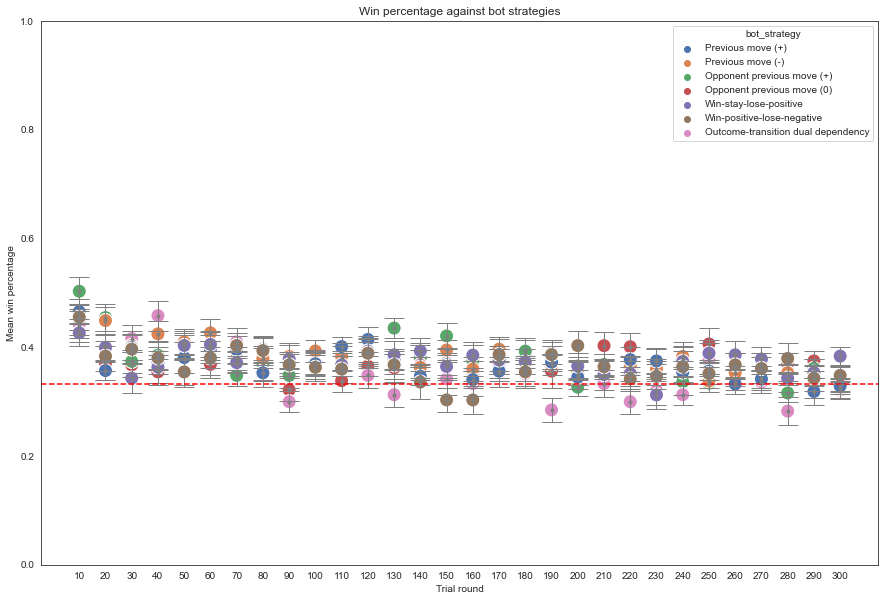

In [7]:

N_ROUNDS = 300
def groupby_f_data(f_data, colname, bins):
    """
    group by filtered data with player outcome and calculate the win percentage
    colname will be either 'player_outcome' or 'agent_outcome' for plotting human or agent results
    """
    modified_f_data = f_data.dropna()
    labs = [str(int(round(a * (N_ROUNDS / bins), 0))) for a in range(1, bins + 1)]
    modified_f_data['bin'] = pd.cut(modified_f_data.loc[:, ('round_index')], bins, labels = labs)
    grouped_data = modified_f_data[['bot_strategy', 'player_id','bin', colname]].groupby(
        ['bot_strategy', 'player_id', 'bin'])[colname].value_counts('count').rename('pct').reset_index()
    
    return grouped_data


def win_summary(grouped_data, colname):
    """
    filter out the win data and add mean, SD, and SEM
    colname will be either 'player_outcome' or 'agent_outcome' for plotting human or agent results
    """
    win_data = grouped_data[grouped_data[colname] == 'win'].reset_index()
    win_summary = win_data[['bot_strategy', 'bin', 'pct']].groupby(
        ['bot_strategy', 'bin'])['pct'].agg(
            [np.mean, np.std, stats.sem]).reset_index()
    
    return win_summary


def plot_win_rates(data):
    """
    generate plot displaying win rates against each bot, binned by rounds
    """
    sns.set_style(style='white')
    data['bot_strategy'] = data['bot_strategy'].replace([
        'prev_move_positive', 'prev_move_negative', 
        'opponent_prev_move_positive', 'opponent_prev_move_nil',
        'win_nil_lose_positive', 'win_positive_lose_negative',
        'outcome_transition_dual_dependency'
    ],
    [
        'Previous move (+)', 'Previous move (-)',
        'Opponent previous move (+)', 'Opponent previous move (0)',
        'Win-stay-lose-positive', 'Win-positive-lose-negative',
        'Outcome-transition dual dependency'
    ])
    
    f, ax = plt.subplots(figsize=(15, 10))
    g = sns.scatterplot(
        x = "bin", y = "mean", hue = "bot_strategy", 
        hue_order = [
            'Previous move (+)', 'Previous move (-)',
            'Opponent previous move (+)', 'Opponent previous move (0)',
            'Win-stay-lose-positive', 'Win-positive-lose-negative',
            'Outcome-transition dual dependency'
        ],
        palette="deep", s = 200, ax = ax, data = data)
    
    plt.errorbar(data.get('bin'), data.get('mean'), yerr = data.get('sem'), 
        fmt = '.', ecolor='0.5', color='0.5',
        capsize = 10 , elinewidth = 1, capthick = 1)
    plt.ylim(0, 1.0)
    plt.title('Win percentage against bot strategies')
    plt.xlabel('Trial round')
    plt.ylabel('Mean win percentage')
    plt.axhline(y = 1/3, color = 'r', linestyle = '--')
    
    return g

plot_win_rates(win_summary(groupby_f_data(df_3a,'agent_outcome',30),'agent_outcome'))


### 3b human_past_current_reward_move

In [8]:
def human_reward_past_cur_move(sub_df):
    dic_reward={'win':3,'tie':0,'loss':-1}
    dic_move={'rock':{'rock':0,'paper':0,'scissors':0},'paper':{'rock':0,'paper':0,'scissors':0},
    'scissors':{'rock':0,'paper':0,'scissors':0}}
    for i in range(2,len(sub_df),2):
        outcome=sub_df.get('player_outcome').iloc[i]
        pre_move=sub_df.get('player_move').iloc[i-2]
        cur_move=sub_df.get('player_move').iloc[i]
        if pre_move != 'none'and not pd.isna(pre_move) and cur_move != 'none'and not pd.isna(cur_move): # this line may skip nan row, reward may look like 0,0,0
            dic_move[pre_move][cur_move]+=dic_reward[outcome]
            # col_name=pre_move+'_'+cur_move+'_reward'
            sub_df.at[i,'rock_rock_reward']=dic_move['rock']['rock']
            sub_df.at[i,'rock_paper_reward']=dic_move['rock']['paper']
            sub_df.at[i,'rock_scissors_reward']=dic_move['rock']['scissors']
            sub_df.at[i,'paper_rock_reward']=dic_move['paper']['rock']
            sub_df.at[i,'paper_paper_reward']=dic_move['paper']['paper']
            sub_df.at[i,'paper_scissors_reward']=dic_move['paper']['scissors']
            sub_df.at[i,'scissors_rock_reward']=dic_move['scissors']['rock']
            sub_df.at[i,'scissors_paper_reward']=dic_move['scissors']['paper']
            sub_df.at[i,'scissors_scissors_reward']=dic_move['scissors']['scissors']
    
    return sub_df 



separated = separate_df(df)
for e in separated:
    human_reward_past_cur_move(e)
# df with human reward based on human past and human current moves
df = pd.concat(separated) 


In [9]:
def get_softmax_probabilities_3b(df):
    # df.dropna(axis = 0)
    distribution = []
    vals=[[0.33,0.33,0.33]] # has deleted one default prob list
    for i in range(2,df.shape[0],2):
        pre_move=df.get('player_move').iloc[i-2]
        if pre_move != 'none' and not pd.isna(pre_move):
            reward_cols=[f'{pre_move}_rock_reward',f'{pre_move}_paper_reward',f'{pre_move}_scissors_reward']
            val = df[reward_cols].iloc[i].tolist()
            vals.append(val)
        else:
            val=vals[-1]
            vals.append(val)
    soft_max=[softmax(x) for x in vals] # delete beta=4, otherwise give me list of 12 instead of 3
    sofm = pd.DataFrame(soft_max, columns = ['softmax_prob_rock', 'softmax_prob_paper', 'softmax_prob_scissors'])
    
    # strip only human df outside of the function
    df_new = df[df.is_bot == 0].reset_index()
    df_new = pd.concat([df_new,sofm], axis = 1)
    return df_new

In [10]:
def pick_move_3b(df):
    moves = np.array([])
    for i in range(df.shape[0]):
        move_choices = ['rock', 'paper', 'scissors']
        distribution = df[['softmax_prob_rock', 'softmax_prob_paper', 'softmax_prob_scissors']].iloc[i].tolist() # get ith [rock_prob,paper_prob,scissors_prob] from input df 
        chosen_move = random.choices(move_choices, distribution) 
        moves = np.append(moves, chosen_move)
    df = df.assign(agent_move = moves) # agent_move stores sampled moves
    return df

In [11]:
separated = separate_df(df)
df_result_3b = pd.DataFrame()
for e in separated:
    e = get_softmax_probabilities_3b(e)
    e=pick_move_3b(e)
    e['agent_outcome'] = e.apply(lambda x: evaluate_outcome(x['agent_move'], x['opponent_move']), axis=1)
    df_result_3b=pd.concat([df_result_3b,e],axis=0)

/var/folders/tm/sjjwcmbs3250mhfs5psrzf5w0000gn/T/ipykernel_57245/2958750840.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_f_data['bin'] = pd.cut(modified_f_data.loc[:, ('round_index')], bins, labels = labs)


<AxesSubplot:title={'center':'Win percentage against bot strategies'}, xlabel='Trial round', ylabel='Mean win percentage'>

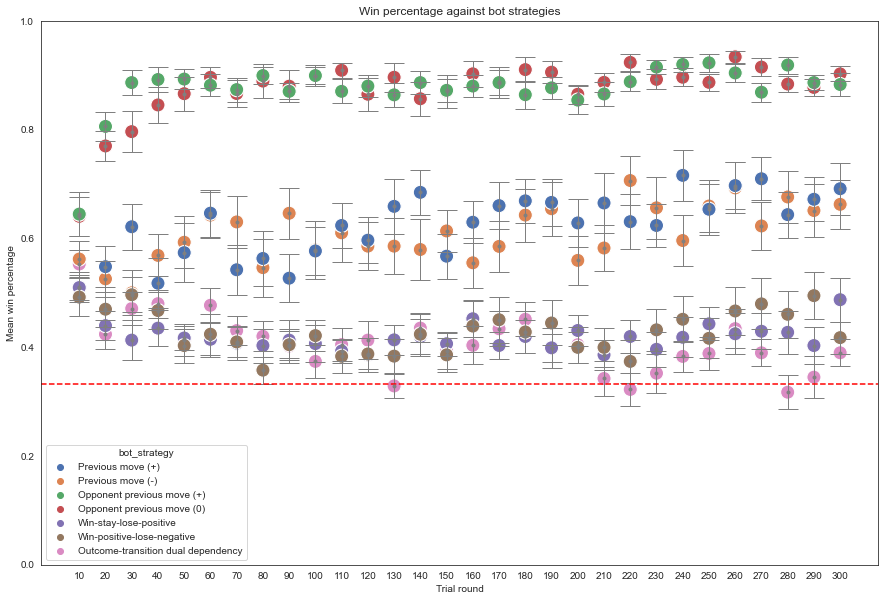

In [12]:
plot_win_rates(win_summary(groupby_f_data(df_result_3b,'agent_outcome',30),'agent_outcome'))

### 3c opponent_past_human_current_reward_move

In [13]:
def human_reward_oppo_past_cur_move(sub_df):
    '''
    tally rewards based on both opponent past and human current moves
    '''
    dic_reward={'win':3,'tie':0,'loss':-1}
    dic_move={'rock':{'rock':0,'paper':0,'scissors':0},'paper':{'rock':0,'paper':0,'scissors':0},
    'scissors':{'rock':0,'paper':0,'scissors':0}}
    for i in range(2,len(sub_df),2):
        outcome=sub_df.get('player_outcome').iloc[i]
        oppo_pre_move=sub_df.get('player_move').iloc[i-1]
        cur_move=sub_df.get('player_move').iloc[i]
        if oppo_pre_move != 'none'and not pd.isna(oppo_pre_move) and cur_move != 'none'and not pd.isna(cur_move): # this line may skip nan row, reward may look like 0,0,0
            dic_move[oppo_pre_move][cur_move]+=dic_reward[outcome]
            col_name='opponent_'+oppo_pre_move+'_'+cur_move+'_reward'
            sub_df.at[i,'opponent_rock_rock_reward']=dic_move['rock']['rock']
            sub_df.at[i,'opponent_rock_paper_reward']=dic_move['rock']['paper']
            sub_df.at[i,'opponent_rock_scissors_reward']=dic_move['rock']['scissors']
            sub_df.at[i,'opponent_paper_rock_reward']=dic_move['paper']['rock']
            sub_df.at[i,'opponent_paper_paper_reward']=dic_move['paper']['paper']
            sub_df.at[i,'opponent_paper_scissors_reward']=dic_move['paper']['scissors']
            sub_df.at[i,'opponent_scissors_rock_reward']=dic_move['scissors']['rock']
            sub_df.at[i,'opponent_scissors_paper_reward']=dic_move['scissors']['paper']
            sub_df.at[i,'opponent_scissors_scissors_reward']=dic_move['scissors']['scissors'] 
    return sub_df 

In [14]:
# separate df into same game id
separated = separate_df(df)
for e in separated:
    human_reward_oppo_past_cur_move(e)
df = pd.concat(separated)

,game_id,version,is_sona_autocredit,sona_experiment_id,sona_credit_token,sona_survey_code,round_index,player_id,is_bot,bot_strategy,...,scissors_scissors_reward,opponent_rock_rock_reward,opponent_rock_paper_reward,opponent_rock_scissors_reward,opponent_paper_rock_reward,opponent_paper_paper_reward,opponent_paper_scissors_reward,opponent_scissors_rock_reward,opponent_scissors_paper_reward,opponent_scissors_scissors_reward
0,30aea025-4c7b-41c0-bd03-363cc73bf583,2,1,1768,19421bc286424246b6b1e873e7a55a8e,32028,1,c82739a2-9e24-4c1b-840f-9eb00d10cd9b,0,outcome_transition_dual_dependency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30aea025-4c7b-41c0-bd03-363cc73bf583,2,1,1768,19421bc286424246b6b1e873e7a55a8e,32028,1,f1c3a029-e381-4f79-afbe-677ef9416f04,1,outcome_transition_dual_dependency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30aea025-4c7b-41c0-bd03-363cc73bf583,2,1,1768,19421bc286424246b6b1e873e7a55a8e,32028,2,c82739a2-9e24-4c1b-840f-9eb00d10cd9b,0,outcome_transition_dual_dependency,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30aea025-4c7b-41c0-bd03-363cc73bf583,2,1,1768,19421bc286424246b6b1e873e7a55a8e,32028,2,f1c3a029-e381-4f79-afbe-677ef9416f04,1,outcome_transition_dual_dependency,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30aea025-4c7b-41c0-bd03-363cc73bf583,2,1,1768,19421bc286424246b6b1e873e7a55a8e,32028,3,c82739a2-9e24-4c1b-840f-9eb00d10cd9b,0,outcome_transition_dual_dependency,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,89fe5868-3da2-45b8-9687-8aec90b283f2,2,1,1768,19421bc286424246b6b1e873e7a55a8e,27853,298,aaef3106-84a2-4e42-a31f-4bcaa7c659dd,1,opponent_prev_move_positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,89fe5868-3da2-45b8-9687-8aec90b283f2,2,1,1768,19421bc286424246b6b1e873e7a55a8e,27853,299,9abb892e-7543-47bf-a2dc-40b0796b01b7,0,opponent_prev_move_positive,...,-4.0,83.0,15.0,28.0,35.0,99.0,15.0,5.0,33.0,84.0
597,89fe5868-3da2-45b8-9687-8aec90b283f2,2,1,1768,19421bc286424246b6b1e873e7a55a8e,27853,299,aaef3106-84a2-4e42-a31f-4bcaa7c659dd,1,opponent_prev_move_positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,89fe5868-3da2-45b8-9687-8aec90b283f2,2,1,1768,19421bc286424246b6b1e873e7a55a8e,27853,300,9abb892e-7543-47bf-a2dc-40b0796b01b7,0,opponent_prev_move_positive,...,-4.0,83.0,15.0,28.0,35.0,99.0,18.0,5.0,33.0,84.0


In [15]:
def get_softmax_probabilities_3c(df):
    '''
    generate softmax probability distribution of each round so we can sample moves from the distribution
    '''
    # df.dropna(axis = 0)
    distribution = []
    vals=[[0.33,0.33,0.33]] # has deleted one default prob list
    for i in range(2,df.shape[0],2):
        pre_move=df.get('player_move').iloc[i-1] # -1 instead of -2 since opponent_pre
        if pre_move != 'none' and not pd.isna(pre_move):
            reward_cols=[f'opponent_{pre_move}_rock_reward',f'opponent_{pre_move}_paper_reward',f'opponent_{pre_move}_scissors_reward']
            val = df[reward_cols].iloc[i].tolist()
            vals.append(val)
        else:
            val=vals[-1]
            vals.append(val)
    soft_max=[softmax(x) for x in vals] 
    sofm = pd.DataFrame(soft_max, columns = ['softmax_prob_rock', 'softmax_prob_paper', 'softmax_prob_scissors'])
    
    # strip only human df outside of the function
    df_new = df[df.is_bot == 0].reset_index()
    df_new = pd.concat([df_new,sofm], axis = 1)
    return df_new

In [16]:
def pick_move_3c(df):
    '''
    sample agent move based on softmax distribution
    '''
    moves = np.array([])
    for i in range(df.shape[0]):
        move_choices = ['rock', 'paper', 'scissors']
        distribution = df[['softmax_prob_rock', 'softmax_prob_paper', 'softmax_prob_scissors']].iloc[i].tolist() # get ith [rock_prob,paper_prob,scissors_prob] from input df 
        chosen_move = random.choices(move_choices, distribution) 
        moves = np.append(moves, chosen_move)
    df = df.assign(agent_move = moves) # agent_move stores sampled moves
    return df

In [17]:
separated = separate_df(df)
df_result_3c = pd.DataFrame()
# align results from the generaed agent move and opponent move
for e in separated:
    e = get_softmax_probabilities_3c(e)
    e=pick_move_3c(e)
    e['agent_outcome'] = e.apply(lambda x: evaluate_outcome(x['agent_move'], x['opponent_move']), axis=1)
    df_result_3c=pd.concat([df_result_3c,e],axis=0)

/var/folders/tm/sjjwcmbs3250mhfs5psrzf5w0000gn/T/ipykernel_57245/2958750840.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_f_data['bin'] = pd.cut(modified_f_data.loc[:, ('round_index')], bins, labels = labs)


<AxesSubplot:title={'center':'Win percentage against bot strategies'}, xlabel='Trial round', ylabel='Mean win percentage'>

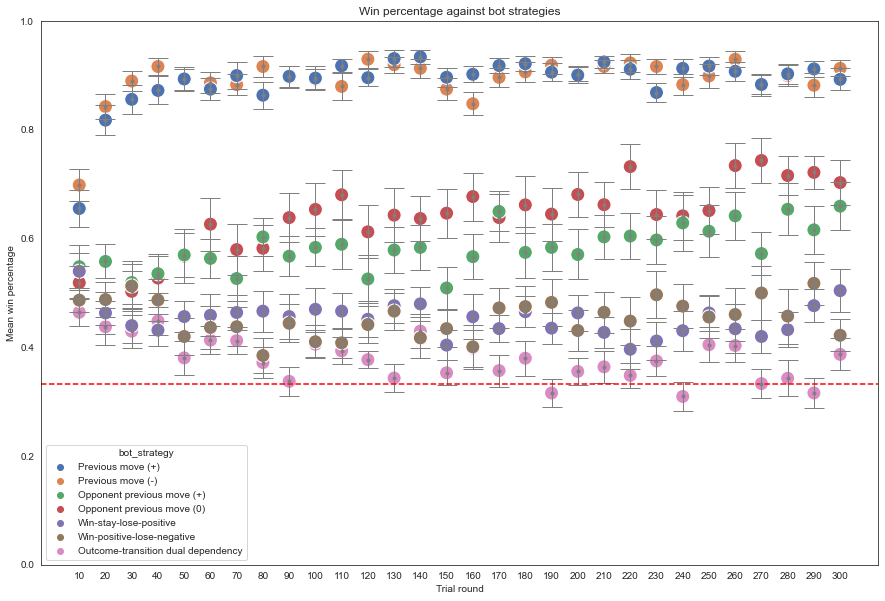

In [18]:
plot_win_rates(win_summary(groupby_f_data(df_result_3c,'agent_outcome',30),'agent_outcome'))